# 2D Segmentation with FPN & ResNet34
### NN Final Project
Khyatee Desai<br>
May 2024

This notebook walks through the process of identifying and segmenting lung cancer within CT scan images of lungs, provided by the [Lung cancer segmentation dataset](https://data.mendeley.com/datasets/5rr22hgzwr/1) dataset.
<br><br>*Code is adapted from this [tutorial](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb)*

In [10]:
# !pip install segmentation-models-pytorch
# !pip install pytorch-lightning

In [9]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
from pprint import pprint
from torch.utils.data import DataLoader
import pandas as pd
import gc

## Dataset

We will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [5]:
from google.colab import drive
drive.mount('/content/drive')

test_data = pickle.load(open('/content/drive/My Drive/Neural Nets/Final Project/lung_data/lung_cancer_test.pkl', 'rb'))

train_data = pickle.load(open('/content/drive/My Drive/Neural Nets/Final Project/lung_data/lung_cancer_train.pkl', 'rb'))



Mounted at /content/drive


In [ ]:
data = pd.concat([test_data, train_data], ignore_index=True)
train_data = data.sample(800)
test_data = data.drop(train_data.index)


In [ ]:
train_tensor = []
for i in range(len(train_data)):
  img_tensor = np.array(train_data.iloc[i]['hu_array'])
  img_tensor = torch.from_numpy(img_tensor)
  mask_tensor = np.array(train_data.iloc[i]['mask'])
  mask_tensor = torch.from_numpy(mask_tensor)
  train_tensor.append((img_tensor.unsqueeze(0), mask_tensor.unsqueeze(0)))
train_dataloader = DataLoader(train_tensor, batch_size=16, shuffle=True, num_workers= os.cpu_count())


test_tensor = []
for i in range(len(test_data)):
  img_tensor = np.array(test_data.iloc[i]['hu_array'])
  img_tensor = torch.from_numpy(img_tensor)
  mask_tensor = np.array(test_data.iloc[i]['mask'])
  mask_tensor = torch.from_numpy(mask_tensor)
  test_tensor.append((img_tensor.unsqueeze(0), mask_tensor.unsqueeze(0)))
test_dataloader = DataLoader(test_tensor, batch_size=16, shuffle=False, num_workers= os.cpu_count())


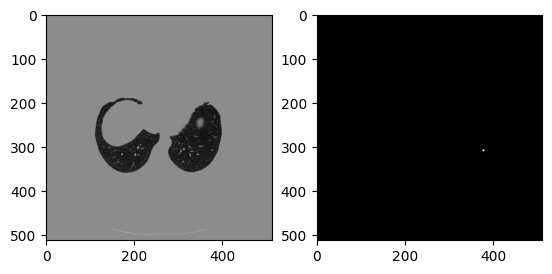

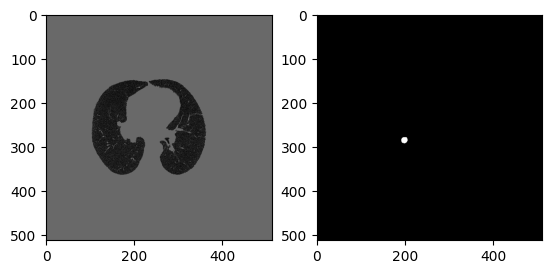

In [ ]:
# lets look at some samples

sample = data.iloc[0]
plt.subplot(1,2,1)
plt.imshow(sample["hu_array"], cmap='gray') #.transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = data.iloc[230]
plt.subplot(1,2,1)
plt.imshow(sample["hu_array"], cmap='gray') #.transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask
plt.show()


In [ ]:
del(test_data)
gc.collect()

11746

## Model

In [11]:
class NN(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        self.train_step_outputs = {'loss':[], 'tp':[], 'fp':[], 'tn':[], 'fn':[]}
        self.validation_step_outputs = {'loss':[], 'tp':[], 'fp':[], 'tn':[], 'fn':[]}
        self.epoch_outputs = {'train':{'loss':[], 'precision':[], 'recall':[]},
                              'val':{'loss':[], 'precision':[], 'recall':[]}}

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image.float())

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        if stage == "train":
          self.train_step_outputs['loss'].append(loss)
          self.train_step_outputs['tp'].append(tp)
          self.train_step_outputs['fp'].append(fp)
          self.train_step_outputs['tn'].append(tn)
          self.train_step_outputs['fn'].append(fn)

        else:
          self.validation_step_outputs['loss'].append(loss)
          self.validation_step_outputs['tp'].append(tp)
          self.validation_step_outputs['fp'].append(fp)
          self.validation_step_outputs['tn'].append(tn)
          self.validation_step_outputs['fn'].append(fn)

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        # tp = torch.cat([x["tp"] for x in outputs])
        # fp = torch.cat([x["fp"] for x in outputs])
        # fn = torch.cat([x["fn"] for x in outputs])
        # tn = torch.cat([x["tn"] for x in outputs])

        # if stage == "train":
        #   self.epoch_outputs['train']['tp'].append(tp)
        # else:
        #   self.epoch_outputs['val']['tp'].append(tp)

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        tp = torch.cat(self.train_step_outputs["tp"]).sum()
        fp = torch.cat(self.train_step_outputs["fp"]).sum()
        fn = torch.cat(self.train_step_outputs["fn"]).sum()

        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        self.epoch_outputs['train']['precision'].append(precision)
        self.epoch_outputs['train']['recall'].append(recall)

        epoch_avg_loss = torch.stack(self.train_step_outputs['loss']).mean()
        print(f"train epoch [{len(self.epoch_outputs['train']['loss'])}] average: {epoch_avg_loss}")
        self.epoch_outputs['train']['loss'].append(epoch_avg_loss)
        self.train_step_outputs = {'loss':[], 'tp':[], 'fp':[], 'tn':[], 'fn':[]}


    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        tp = torch.cat(self.validation_step_outputs["tp"]).sum()
        fp = torch.cat(self.validation_step_outputs["fp"]).sum()
        fn = torch.cat(self.validation_step_outputs["fn"]).sum()

        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        self.epoch_outputs['val']['precision'].append(precision)
        self.epoch_outputs['val']['recall'].append(recall)

        epoch_avg_loss = torch.stack(self.validation_step_outputs['loss']).mean()
        print(f"val epoch [{len(self.epoch_outputs['val']['loss'])}] average: {epoch_avg_loss}")
        self.epoch_outputs['val']['loss'].append(epoch_avg_loss)
        self.validation_step_outputs = {'loss':[], 'tp':[], 'fp':[], 'tn':[], 'fn':[]}


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)


In [ ]:
model = NN("FPN", "resnet34", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 56.6MB/s]


## Training

In [ ]:
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto"
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=test_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val epoch [0] average: 0.9987295866012573


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [1] average: 0.6399755477905273
train epoch [0] average: 0.7886175513267517


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [2] average: 0.42833536863327026
train epoch [1] average: 0.3974825143814087


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [3] average: 0.32280388474464417
train epoch [2] average: 0.2792685627937317


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [4] average: 0.25843945145606995
train epoch [3] average: 0.2075030505657196


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [5] average: 0.25049543380737305
train epoch [4] average: 0.18824312090873718


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [6] average: 0.2184915989637375
train epoch [5] average: 0.1789221465587616


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [7] average: 0.19668789207935333
train epoch [6] average: 0.15299224853515625


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [8] average: 0.1779049038887024
train epoch [7] average: 0.14668607711791992


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [9] average: 0.17804616689682007
train epoch [8] average: 0.13952940702438354


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [10] average: 0.1685759425163269
train epoch [9] average: 0.13459011912345886


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [11] average: 0.16888035833835602
train epoch [10] average: 0.1307963728904724


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [12] average: 0.16588498651981354
train epoch [11] average: 0.12322445958852768


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [13] average: 0.1592463254928589
train epoch [12] average: 0.12758003175258636


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [14] average: 0.1589978188276291
train epoch [13] average: 0.1202269122004509


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [15] average: 0.15350602567195892
train epoch [14] average: 0.12172488868236542


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [16] average: 0.15249718725681305
train epoch [15] average: 0.12855522334575653


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [17] average: 0.15305501222610474
train epoch [16] average: 0.11883396655321121


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [18] average: 0.1493646204471588
train epoch [17] average: 0.11588131636381149


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [19] average: 0.14556832611560822
train epoch [18] average: 0.11348547041416168


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [20] average: 0.14808592200279236
train epoch [19] average: 0.11178796738386154


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [21] average: 0.1447262167930603
train epoch [20] average: 0.11026590317487717


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [22] average: 0.14427319169044495
train epoch [21] average: 0.10572944581508636


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [23] average: 0.14016157388687134
train epoch [22] average: 0.10779119282960892


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [24] average: 0.15295062959194183
train epoch [23] average: 0.11060290783643723


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [25] average: 0.13919055461883545
train epoch [24] average: 0.1058911606669426


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [26] average: 0.1373409777879715
train epoch [25] average: 0.10650672763586044


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [27] average: 0.13666461408138275
train epoch [26] average: 0.10029810667037964


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [28] average: 0.13606968522071838
train epoch [27] average: 0.09868514537811279


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [29] average: 0.1347125619649887
train epoch [28] average: 0.10022217780351639


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [30] average: 0.13651615381240845
train epoch [29] average: 0.10061168670654297


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [31] average: 0.1328153908252716
train epoch [30] average: 0.09918919950723648


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [32] average: 0.1314835101366043
train epoch [31] average: 0.09957395493984222


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [33] average: 0.13029463589191437
train epoch [32] average: 0.10008107125759125


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [34] average: 0.1332014799118042
train epoch [33] average: 0.10119939595460892


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [35] average: 0.13491250574588776
train epoch [34] average: 0.0960458517074585


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [36] average: 0.13262885808944702
train epoch [35] average: 0.09636441618204117


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [37] average: 0.27159878611564636
train epoch [36] average: 0.12511590123176575


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [38] average: 0.16877983510494232
train epoch [37] average: 0.15530072152614594


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [39] average: 0.1462365984916687
train epoch [38] average: 0.1281268447637558


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [40] average: 0.1426970511674881
train epoch [39] average: 0.10492540150880814


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [41] average: 0.1375615894794464
train epoch [40] average: 0.09782983362674713


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [42] average: 0.13374729454517365
train epoch [41] average: 0.09486965835094452


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [43] average: 0.12905430793762207
train epoch [42] average: 0.09373351186513901


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [44] average: 0.12845046818256378
train epoch [43] average: 0.09395000338554382


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [45] average: 0.12800544500350952
train epoch [44] average: 0.09288717061281204


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [46] average: 0.12852609157562256
train epoch [45] average: 0.08893079310655594


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [47] average: 0.12830103933811188
train epoch [46] average: 0.08556180447340012


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [48] average: 0.1402188539505005
train epoch [47] average: 0.10683010518550873


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [49] average: 0.13592040538787842
train epoch [48] average: 0.09436939656734467


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [50] average: 0.13038384914398193
train epoch [49] average: 0.09508661180734634


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [51] average: 0.12832655012607574
train epoch [50] average: 0.08787534385919571


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [52] average: 0.12571299076080322
train epoch [51] average: 0.08618022501468658


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [53] average: 0.1260986179113388
train epoch [52] average: 0.09167056530714035


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [54] average: 0.12585124373435974
train epoch [53] average: 0.0874512568116188


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [55] average: 0.12885721027851105
train epoch [54] average: 0.08249541372060776


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [56] average: 0.12317105382680893
train epoch [55] average: 0.08648484200239182


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [57] average: 0.12658336758613586
train epoch [56] average: 0.08113563060760498


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [58] average: 0.1283138543367386
train epoch [57] average: 0.08147511631250381


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [59] average: 0.1264360249042511
train epoch [58] average: 0.08501565456390381


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [60] average: 0.12329427152872086
train epoch [59] average: 0.08146215230226517


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [61] average: 0.12244381755590439
train epoch [60] average: 0.08216071128845215


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [62] average: 0.1268995702266693
train epoch [61] average: 0.08857595175504684


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [63] average: 0.12313409894704819
train epoch [62] average: 0.08187442272901535


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [64] average: 0.12583254277706146
train epoch [63] average: 0.08033411204814911


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [65] average: 0.12416920065879822
train epoch [64] average: 0.0856282040476799


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [66] average: 0.12255802005529404
train epoch [65] average: 0.0811791867017746


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [67] average: 0.12244419753551483
train epoch [66] average: 0.08146902918815613


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [68] average: 0.12224481999874115
train epoch [67] average: 0.08762965351343155


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [69] average: 0.12427139282226562
train epoch [68] average: 0.07904943078756332


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [70] average: 0.12181683629751205
train epoch [69] average: 0.0789976641535759


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [71] average: 0.12460631132125854
train epoch [70] average: 0.0777381956577301


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [72] average: 0.12197087705135345
train epoch [71] average: 0.07684148848056793


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [73] average: 0.1257585883140564
train epoch [72] average: 0.07816114276647568


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [74] average: 0.12143371999263763
train epoch [73] average: 0.07886739075183868


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [75] average: 0.12196636199951172
train epoch [74] average: 0.07635076344013214


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [76] average: 0.12202736735343933
train epoch [75] average: 0.07434505224227905


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [77] average: 0.12200763076543808
train epoch [76] average: 0.07913137227296829


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [78] average: 0.12177597731351852
train epoch [77] average: 0.0759478434920311


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [79] average: 0.1291903555393219
train epoch [78] average: 0.09126491099596024


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [80] average: 0.12373480200767517
train epoch [79] average: 0.08367138355970383


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [81] average: 0.12180036306381226
train epoch [80] average: 0.07795478403568268


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [82] average: 0.12445968389511108
train epoch [81] average: 0.07885415107011795


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [83] average: 0.12416102737188339
train epoch [82] average: 0.0742262601852417


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [84] average: 0.12512001395225525
train epoch [83] average: 0.07034911215305328


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [85] average: 0.12106124311685562
train epoch [84] average: 0.07583121955394745


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [86] average: 0.11899420619010925
train epoch [85] average: 0.06738578528165817


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [87] average: 0.11947514861822128
train epoch [86] average: 0.06848219782114029


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [88] average: 0.11875595152378082
train epoch [87] average: 0.06708090007305145


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [89] average: 0.11912374198436737
train epoch [88] average: 0.06923669576644897


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [90] average: 0.11706458777189255
train epoch [89] average: 0.06758236885070801


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [91] average: 0.11901003122329712
train epoch [90] average: 0.0663071870803833


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [92] average: 0.11812075972557068
train epoch [91] average: 0.06875606626272202


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [93] average: 0.1185138151049614
train epoch [92] average: 0.0660504698753357


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [94] average: 0.122430719435215
train epoch [93] average: 0.06960569322109222


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [95] average: 0.11860393732786179
train epoch [94] average: 0.06651049107313156


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [96] average: 0.11875466257333755
train epoch [95] average: 0.06697215139865875


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [97] average: 0.12324129790067673
train epoch [96] average: 0.07012087851762772


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [98] average: 0.11839655786752701
train epoch [97] average: 0.06299933046102524


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [99] average: 0.11513780057430267
train epoch [98] average: 0.0661669597029686


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch [100] average: 0.11668257415294647
train epoch [99] average: 0.06437502056360245


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# torch.save(model, '/content/drive/My Drive/Neural Nets/Final Project/___')

In [12]:
model = torch.load('/content/drive/My Drive/Neural Nets/Final Project/hundred_epochs_w_metrics',map_location=torch.device('cpu'))

In [13]:
model

PetModel(
  (model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

In [ ]:
y.epoch_outputs['train']['loss'][0].detach().numpy()

array(0.78861755, dtype=float32)

## Learning Curves

In [ ]:
train_loss = []
train_dice = []
for val in y.epoch_outputs['train']['loss']:
  train_loss.append(val.detach())
  train_dice.append(1-val.detach())

val_dice = []
for val in y.epoch_outputs['val']['loss']:
  val_dice.append(1-val.detach())

In [ ]:
train_prec = []
for val in y.epoch_outputs['train']['precision']:
  train_prec.append(val.detach())

train_rec = []
for val in y.epoch_outputs['train']['recall']:
  train_rec.append(val.detach())

val_rec = []
for val in y.epoch_outputs['val']['recall']:
  val_rec.append(val.detach())

val_prec = []
for val in y.epoch_outputs['val']['precision']:
  val_prec.append(val.detach())

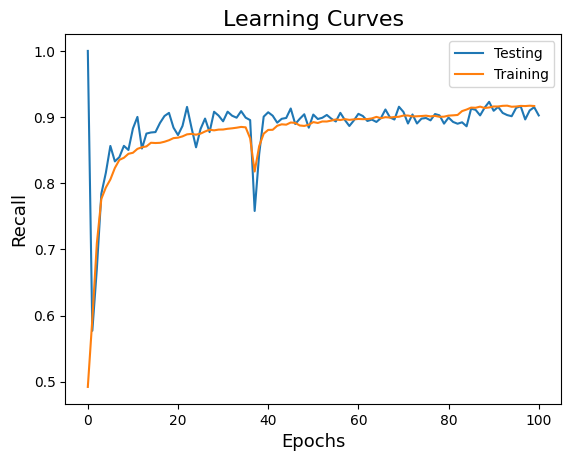

In [ ]:
plt.plot(val_rec, label="Testing");
plt.plot(train_rec, label = "Training");
plt.ylabel('Recall', fontsize=13);
plt.xlabel('Epochs', fontsize=13);
plt.legend();
plt.title("Learning Curves", fontsize=16);

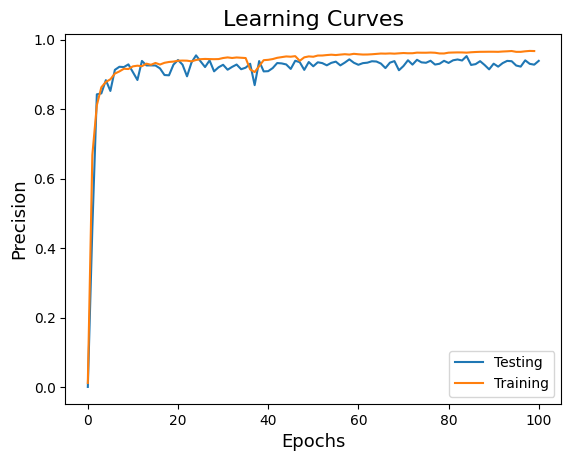

In [ ]:
plt.plot(val_prec, label="Testing");
plt.plot(train_prec, label = "Training");
plt.ylabel('Precision', fontsize=13);
plt.xlabel('Epochs', fontsize=13);
plt.legend();
plt.title("Learning Curves", fontsize=16);

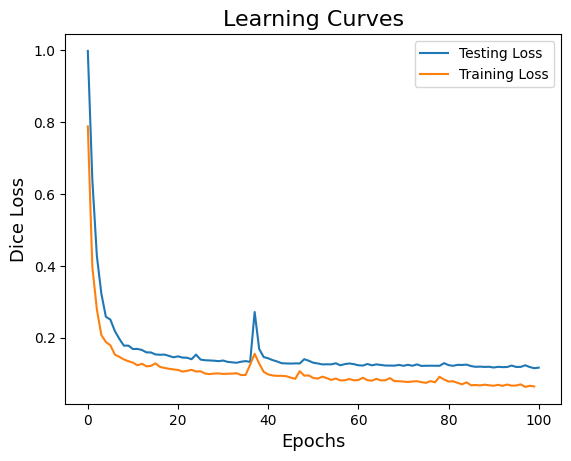

In [ ]:
import matplotlib.pyplot as plt

# Dice Loss

plt.plot(y.epoch_outputs['val']['loss'], label="Testing Loss");
plt.plot(train_loss, label = "Training Loss");
plt.ylabel('Dice Loss', fontsize=13);
plt.xlabel('Epochs', fontsize=13);
plt.legend();
plt.title("Learning Curves", fontsize=16);

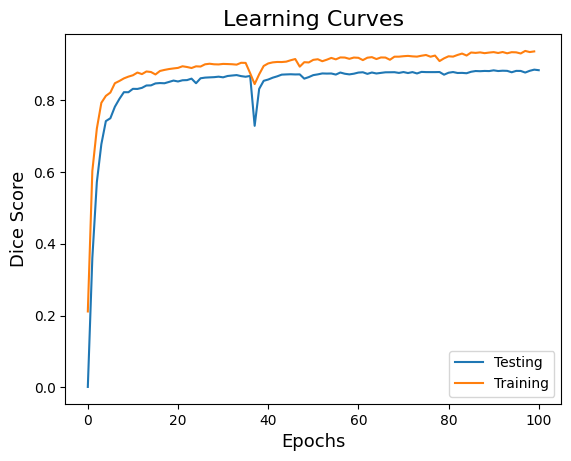

In [ ]:
# Dice Score

plt.plot(val_dice, label="Testing");
plt.plot(train_dice, label = "Training");
plt.ylabel('Dice Score', fontsize=13);
plt.xlabel('Epochs', fontsize=13);
plt.legend();
plt.title("Learning Curves", fontsize=16);

In [ ]:
# 100 epochs, LR= 0.0001
x = torch.load('/content/drive/My Drive/Neural Nets/Final Project/hundred_epochs')

# Result visualization

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


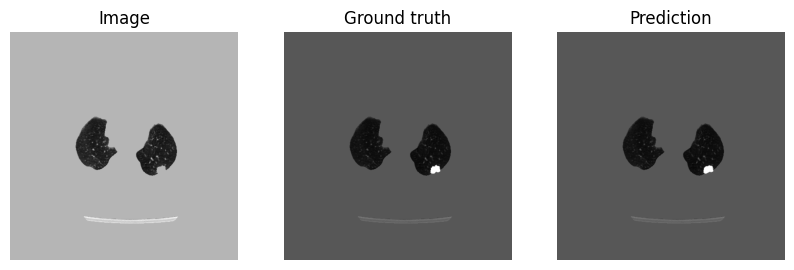

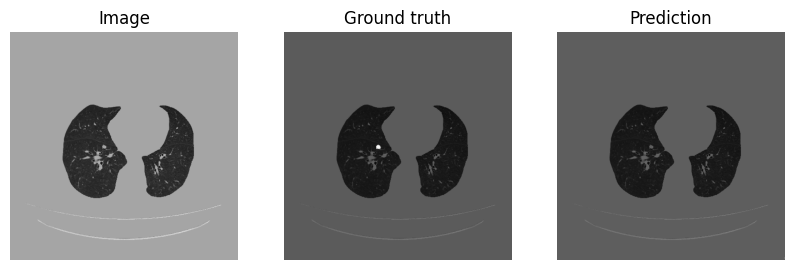

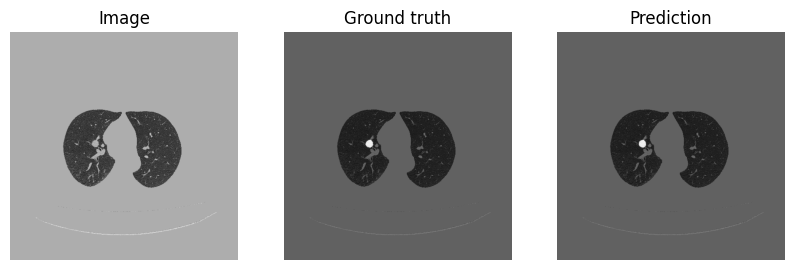

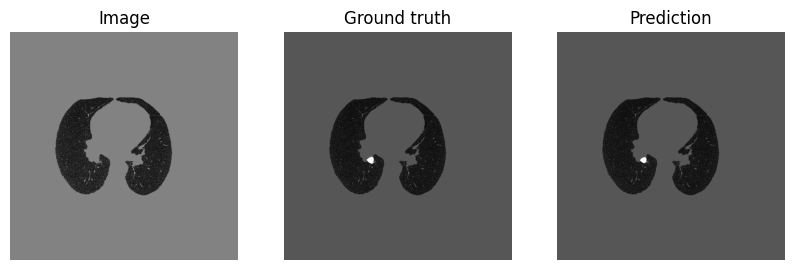

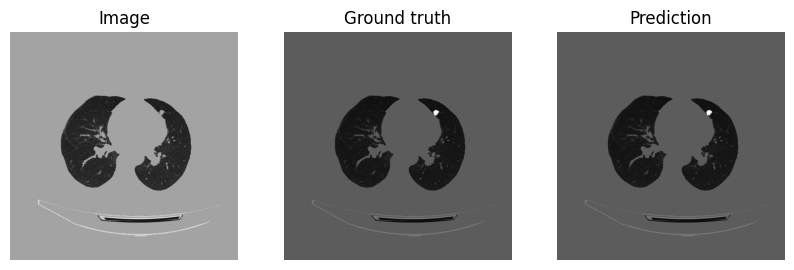

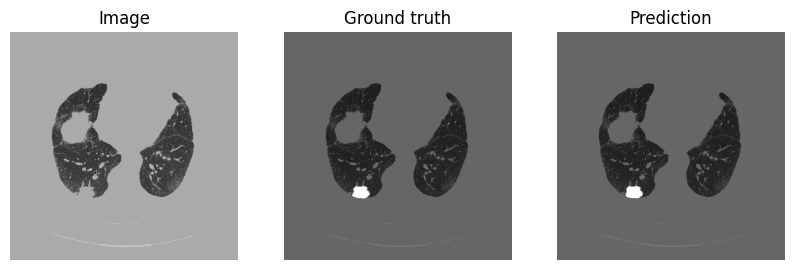

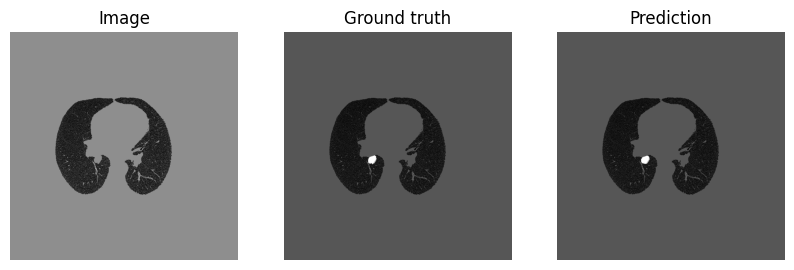

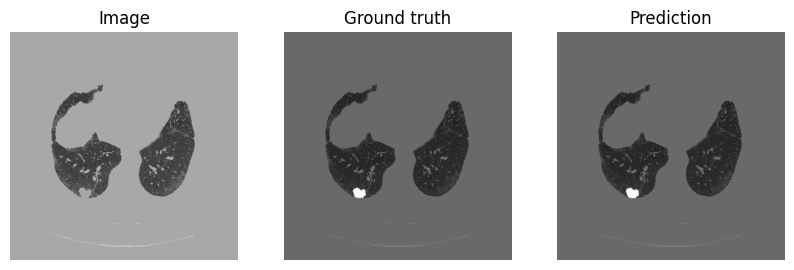

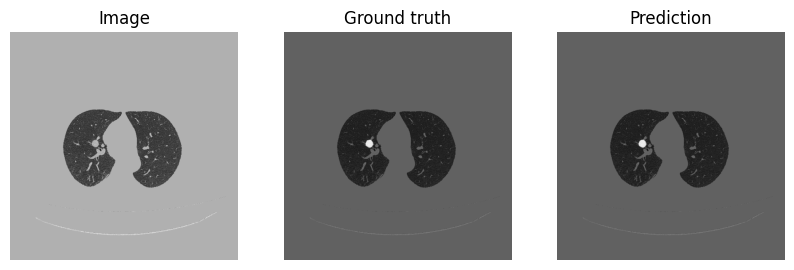

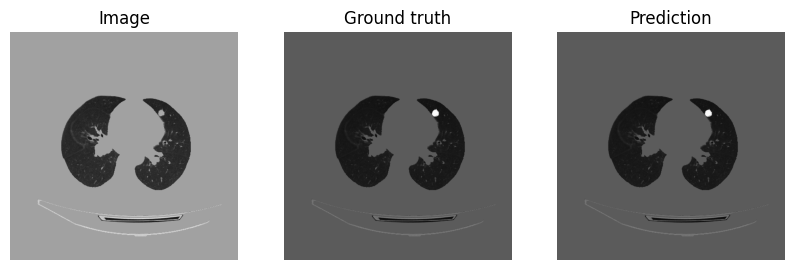

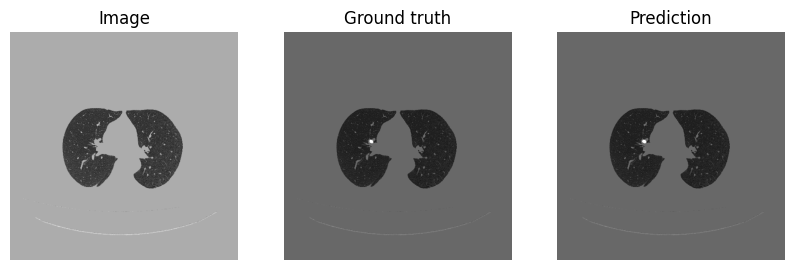

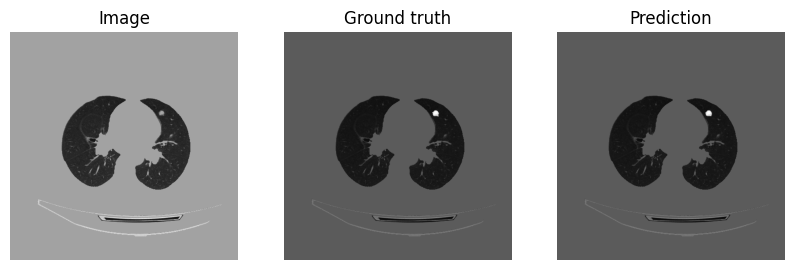

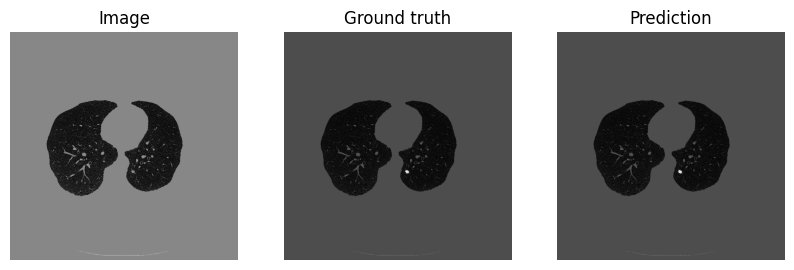

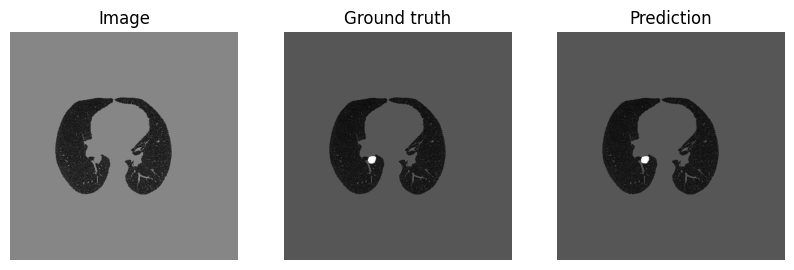

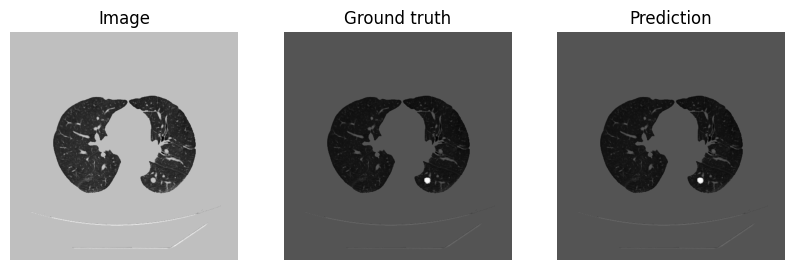

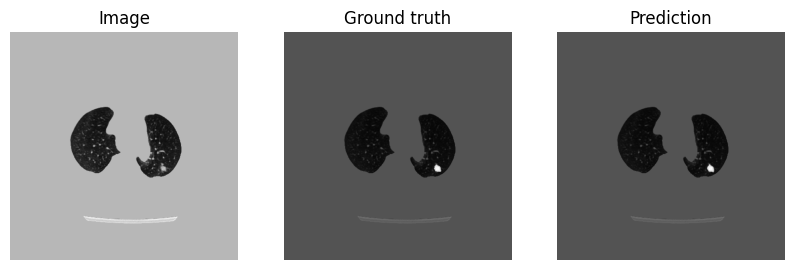

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].float())
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    t = (gt_mask + image* .0005)
    plt.imshow(t.numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    pr_mask = ((pr_mask - pr_mask.min()) / (pr_mask.max() - pr_mask.min()) >.5).int()
    t = (pr_mask + image* .0005)
    plt.imshow(t.numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [ ]:
activation['conv1'][0][2].shape

torch.Size([256, 256])

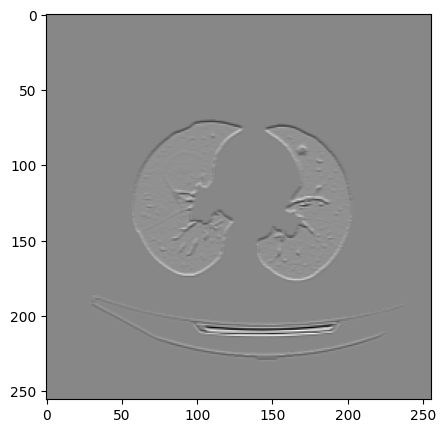

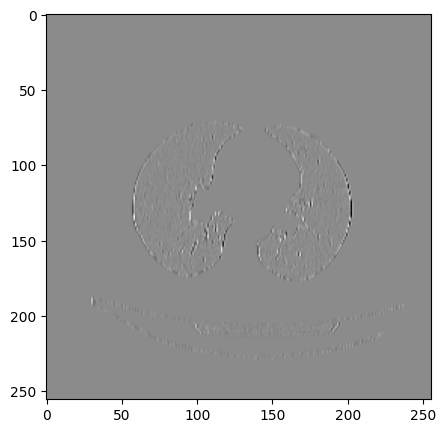

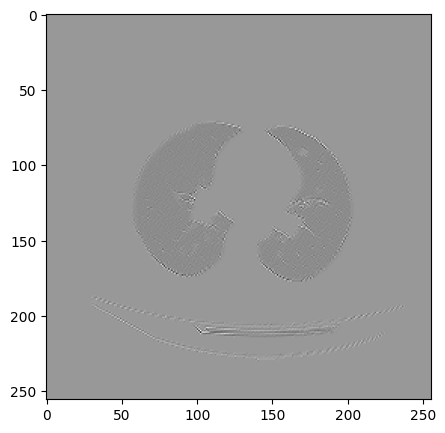

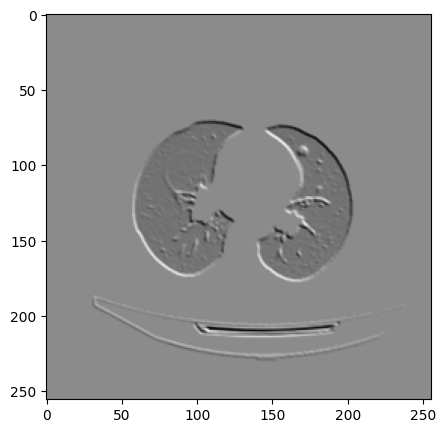

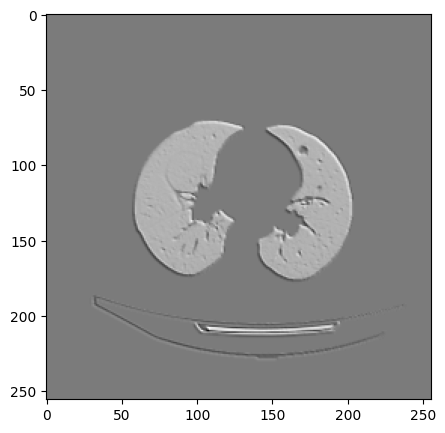

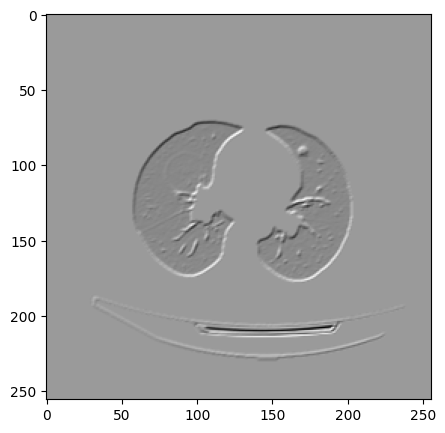

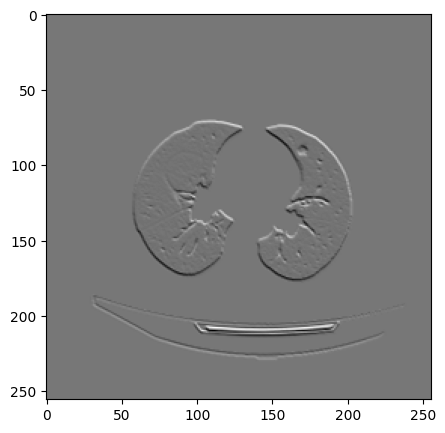

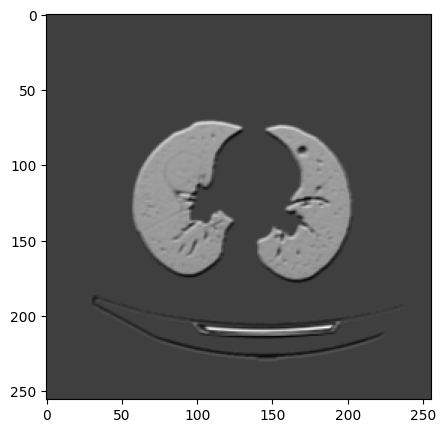

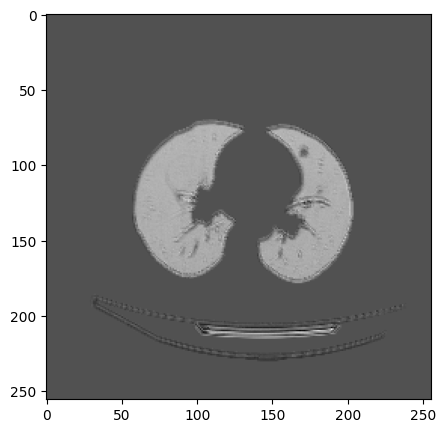

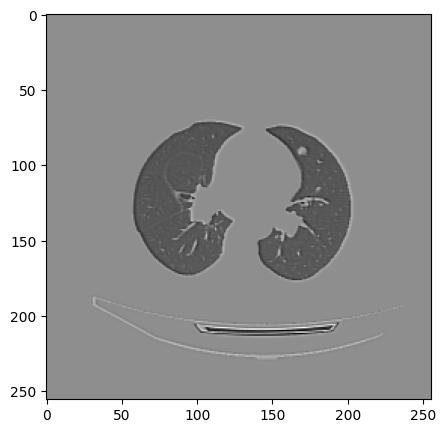

In [ ]:


# Visualize feature maps

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.encoder.conv1.register_forward_hook(get_activation('conv1'))

output = model(batch[0][11][0].float())

for idx in range(10):
  act = activation['conv1'][0][idx]

  plt.figure(figsize=(10, 5))
  plt.imshow(act, cmap='gray');
  plt.show();

In [ ]:
for n, p in model.named_parameters():
  print(n)

model.encoder.conv1.weight
model.encoder.bn1.weight
model.encoder.bn1.bias
model.encoder.layer1.0.conv1.weight
model.encoder.layer1.0.bn1.weight
model.encoder.layer1.0.bn1.bias
model.encoder.layer1.0.conv2.weight
model.encoder.layer1.0.bn2.weight
model.encoder.layer1.0.bn2.bias
model.encoder.layer1.1.conv1.weight
model.encoder.layer1.1.bn1.weight
model.encoder.layer1.1.bn1.bias
model.encoder.layer1.1.conv2.weight
model.encoder.layer1.1.bn2.weight
model.encoder.layer1.1.bn2.bias
model.encoder.layer1.2.conv1.weight
model.encoder.layer1.2.bn1.weight
model.encoder.layer1.2.bn1.bias
model.encoder.layer1.2.conv2.weight
model.encoder.layer1.2.bn2.weight
model.encoder.layer1.2.bn2.bias
model.encoder.layer2.0.conv1.weight
model.encoder.layer2.0.bn1.weight
model.encoder.layer2.0.bn1.bias
model.encoder.layer2.0.conv2.weight
model.encoder.layer2.0.bn2.weight
model.encoder.layer2.0.bn2.bias
model.encoder.layer2.0.downsample.0.weight
model.encoder.layer2.0.downsample.1.weight
model.encoder.layer2.0.

In [ ]:
# results from lr 0.0001, 100 epochs
'''val epoch average: 0.5697620511054993
train epoch average: 0.6984742283821106
val epoch average: 0.42226704955101013
train epoch average: 0.3473484218120575
val epoch average: 0.33595898747444153
train epoch average: 0.21741896867752075
val epoch average: 0.3022722005844116
train epoch average: 0.17563705146312714
val epoch average: 0.2660120725631714
train epoch average: 0.15213318169116974
val epoch average: 0.25899046659469604
train epoch average: 0.14424829185009003
val epoch average: 0.24970191717147827
train epoch average: 0.1369158923625946
val epoch average: 0.24171164631843567
train epoch average: 0.1316937804222107
val epoch average: 0.23462089896202087
train epoch average: 0.12838739156723022
val epoch average: 0.24680201709270477
train epoch average: 0.12827149033546448
val epoch average: 0.23194244503974915
train epoch average: 0.12087181955575943
val epoch average: 0.23056675493717194
train epoch average: 0.12139451503753662
val epoch average: 0.22828060388565063
train epoch average: 0.11376705020666122
val epoch average: 0.20978228747844696
train epoch average: 0.10873503237962723
val epoch average: 0.20579753816127777
train epoch average: 0.10895358771085739
val epoch average: 0.2030058652162552
train epoch average: 0.10692058503627777
val epoch average: 0.2007111757993698
train epoch average: 0.09955999255180359
val epoch average: 0.19614645838737488
train epoch average: 0.10257121175527573
val epoch average: 0.1978641152381897
train epoch average: 0.10154006630182266
val epoch average: 0.19352556765079498
train epoch average: 0.10770634561777115
val epoch average: 0.19238613545894623
train epoch average: 0.09732536226511002
val epoch average: 0.1946190595626831
train epoch average: 0.09817244112491608
val epoch average: 0.1938164085149765
train epoch average: 0.10094993561506271
val epoch average: 0.18710632622241974
train epoch average: 0.09365953505039215
val epoch average: 0.18732455372810364
train epoch average: 0.09256822615861893
val epoch average: 0.18655994534492493
train epoch average: 0.09481455385684967
val epoch average: 0.18351507186889648
train epoch average: 0.09466241300106049
val epoch average: 0.18524006009101868
train epoch average: 0.09097099304199219
val epoch average: 0.1842440813779831
train epoch average: 0.09074363857507706
val epoch average: 0.18128664791584015
train epoch average: 0.09048160165548325
val epoch average: 0.17822059988975525
train epoch average: 0.0897965207695961
val epoch average: 0.1789054572582245
train epoch average: 0.08741842210292816
val epoch average: 0.1739082783460617
train epoch average: 0.08624608814716339
val epoch average: 0.17614315450191498
train epoch average: 0.08507215231657028
val epoch average: 0.18037310242652893
train epoch average: 0.09271159023046494
val epoch average: 0.17394736409187317
train epoch average: 0.0849180668592453
val epoch average: 0.16942362487316132
train epoch average: 0.0848197340965271
val epoch average: 0.16869358718395233
train epoch average: 0.08503446727991104
val epoch average: 0.16779574751853943
train epoch average: 0.08538434654474258
val epoch average: 0.16691355407238007
train epoch average: 0.0844532772898674
val epoch average: 0.1646934151649475
train epoch average: 0.08269209414720535
val epoch average: 0.16372811794281006
train epoch average: 0.08187546581029892
val epoch average: 0.170509472489357
train epoch average: 0.08040487766265869
val epoch average: 0.16691471636295319
train epoch average: 0.07845766842365265
val epoch average: 0.16506721079349518
train epoch average: 0.08379129320383072
val epoch average: 0.16067421436309814
train epoch average: 0.08579783141613007
val epoch average: 0.16138587892055511
train epoch average: 0.0796288251876831
val epoch average: 0.16132232546806335
train epoch average: 0.08098094910383224
val epoch average: 0.15846949815750122
train epoch average: 0.07780931890010834
val epoch average: 0.15759123861789703
train epoch average: 0.08020896464586258
val epoch average: 0.16146576404571533
train epoch average: 0.08131391555070877
val epoch average: 0.1588423252105713
train epoch average: 0.07806011289358139
val epoch average: 0.15801508724689484
train epoch average: 0.08141851425170898
val epoch average: 0.1593640148639679
train epoch average: 0.0788639485836029
val epoch average: 0.1565062403678894
train epoch average: 0.07579997181892395
val epoch average: 0.16166672110557556
train epoch average: 0.08128204196691513
val epoch average: 0.15961426496505737
train epoch average: 0.07968464493751526
val epoch average: 0.16081617772579193
train epoch average: 0.0769881084561348
val epoch average: 0.15734051167964935
train epoch average: 0.07390322536230087
val epoch average: 0.156950905919075
train epoch average: 0.07603279501199722
val epoch average: 0.15765154361724854
train epoch average: 0.07538671791553497
val epoch average: 0.16268794238567352
train epoch average: 0.0834779441356659
val epoch average: 0.16246317327022552
train epoch average: 0.07671556621789932
val epoch average: 0.1551862359046936
train epoch average: 0.0752444937825203
val epoch average: 0.15640957653522491
train epoch average: 0.07863369584083557
val epoch average: 0.15080919861793518
train epoch average: 0.07264496386051178
val epoch average: 0.15162868797779083
train epoch average: 0.07228219509124756
val epoch average: 0.15434756875038147
train epoch average: 0.07698895782232285
val epoch average: 0.16431139409542084
train epoch average: 0.07695049047470093
val epoch average: 0.15782210230827332
train epoch average: 0.07475204765796661
val epoch average: 0.154982790350914
train epoch average: 0.07470047473907471
val epoch average: 0.2878513038158417
train epoch average: 0.1010144054889679
val epoch average: 0.16354218125343323
train epoch average: 0.09538944065570831
val epoch average: 0.15972523391246796
train epoch average: 0.07930836081504822
val epoch average: 0.1562967747449875
train epoch average: 0.07556957006454468
val epoch average: 0.15456436574459076
train epoch average: 0.07749050110578537
val epoch average: 0.15226662158966064
train epoch average: 0.07438810914754868
val epoch average: 0.15316222608089447
train epoch average: 0.07419411838054657
val epoch average: 0.15237587690353394
train epoch average: 0.07348213344812393
val epoch average: 0.150232195854187
train epoch average: 0.07088885456323624
val epoch average: 0.15465475618839264
train epoch average: 0.07560674846172333
val epoch average: 0.15125003457069397
train epoch average: 0.07446085661649704
val epoch average: 0.1483442336320877
train epoch average: 0.07269112020730972
val epoch average: 0.14779239892959595
train epoch average: 0.07241014391183853
val epoch average: 0.14947673678398132
train epoch average: 0.06999824196100235
val epoch average: 0.15209269523620605
train epoch average: 0.08101903647184372
val epoch average: 0.14927077293395996
train epoch average: 0.07609520852565765
val epoch average: 0.14731508493423462
train epoch average: 0.07175632566213608
val epoch average: 0.14629054069519043
train epoch average: 0.06979496031999588
val epoch average: 0.14915034174919128
train epoch average: 0.07497196644544601
val epoch average: 0.14981602132320404
train epoch average: 0.07009509205818176
val epoch average: 0.14890950918197632
train epoch average: 0.07191712409257889
val epoch average: 0.14814242720603943
train epoch average: 0.0706205815076828
val epoch average: 0.14684517681598663
train epoch average: 0.07081005722284317
val epoch average: 0.14548957347869873
train epoch average: 0.06680800765752792
val epoch average: 0.1450767070055008
train epoch average: 0.06670178472995758
val epoch average: 0.14611808955669403
train epoch average: 0.0665411725640297
val epoch average: 0.1476380079984665
train epoch average: 0.0772460550069809
val epoch average: 0.14644351601600647
train epoch average: 0.06892184168100357
val epoch average: 0.14487765729427338
train epoch average: 0.07271406799554825'''